In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(6)

# 1. Examining the data

We will be using k-nearest neighbours to classify and cluster a dataset of faces. We're using the Olivetti dataset, which contains 400 images of 40 people (10 images per person). Each image is 64x64 and in black and white.

Is KNN a good approach to classifying the data?

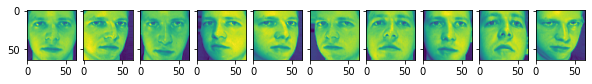

In [2]:
from sklearn import datasets
from mpl_toolkits.axes_grid1 import ImageGrid

x,y = datasets.fetch_olivetti_faces(return_X_y=True)
def plot_images(data):
    num_plots = data.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(data[i].reshape((64,64)))
    plt.show()
plot_images(x[:10])

# 2. Designing the model

Write the steps (or pseudocode) for how to find the k-nearest neighbours.

In [3]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class WeightedKNN:

    def __init__(self, K=3, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return

    def fit(self, x, y):
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self

    def predict(self, x_test):
        n_test = x_test.shape[0]

        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        y_prob = np.zeros((n_test, self.C))
        knns = np.zeros((n_test, self.K), dtype=int)

        # STEP 1. find KNNs of each point
        knns = np.argsort(distances)
        knns = knns[:,:self.K]

        # STEP 2. fill in y_prob
        for k in range(len(knns)):
          for j in range(len(knns[0])):
            image = knns[k][j]
            dist, label = distances[k][image], self.y[image]
            if dist == 0: dist = 1 # to avoid division by 0

            y_prob[k][label] = y_prob[k][label] + 1/dist # add vote weighted by inverse of distance

        # STEP 3. normalize to get probabilities
        def softmax(z):
          z0 = np.max(z,-1, keepdims=True)
          z_exp = np.exp(z - z0)
          p = z_exp / np.sum(z_exp, -1, keepdims=True)
          return p

        return softmax(y_prob), knns

# 3. Hyperparameter tuning


In [4]:
from sklearn.utils import shuffle

def shuffle_and_get_val(x,y,rs,val_size):
  x_shuffle,y_shuffle = shuffle(x, y, random_state = rs)
  x_val,y_val = x_shuffle[:val_size],y_shuffle[:val_size]
  x_train,y_train = x_shuffle[val_size:],y_shuffle[val_size:]

  return x_train,y_train,x_val,y_val

def find_best_k(r,x_train,y_train,x_test,y_test):
  '''
  Returns the k that yields the best accuracy for KNNS classification, and its
  accuracy. If two k's yield the same accuracy, returns the larger one to reduce overfitting.
  r = range of k's to check accuracy for
  '''
  test_size = np.shape(y_test)[0]
  best_k = 0
  best_acc = 0

  for j in range(1,r+1):
    y_prob, neighbours = WeightedKNN(K=j).fit(x_train,y_train).predict(x_test)

    preds = np.argmax(y_prob,1)
    acc = np.sum(preds == y_test)/test_size

    if acc >= best_acc:
      best_k = j
      best_acc = acc

  return best_k, best_acc


# Principal Component Analysis

Each face image has 4096 parameters (pixels). But most of the variance in the data can be explained with far fewer components.

We want a mapping between our data space (4096 dimensions) to a lower dimensional space, without losing too much information. I.e. we want to **faithfully** represent the data with fewer dimensions.

For simplicity, we'll assume this mapping is linear, so we can describe it with a matrix $Q$. We assume $Q$ is orthonormal, with inverse $Q^T$.

We want to minimize the **reconstruction error** given by $\min_Q = \sum_n||x^{(n)} - x^{(n)}QQ^T||_2^2$.

Since $Q$ is orthogonal, we can think of it as a change of coordinates. We want to change the coordinate such that the first $n$ new coordinates best explain the data, for any $n$.

So we want coordinates that emphasize the variance in the data. The first new coordinate should have the maximum variance, the second coordinate should have the second highest variance, etc.

If $X$ is the matrix containing our data, let $\sum = \frac{1}{N}X^TX$ be the covariance matrix.

It turns out that this $Q$ corresponds to the matrix of eigenvectors of $\sum$.

Visualizing the eigenfaces:

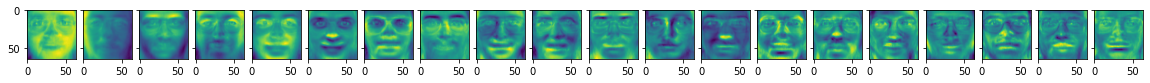

In [5]:
x_norm = x - np.mean(x,axis=0) # normalizing the data

u,s,vt = np.linalg.svd(x_norm, full_matrices=False)
plot_images(vt[:20])


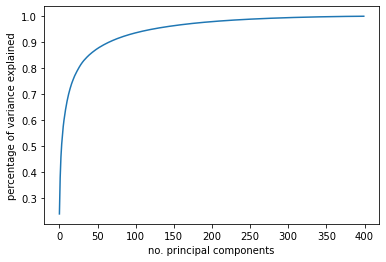

95% of the variance is explained using 123 principal components


In [6]:

variances = np.var(x_norm @ vt.T, axis=0)
var_explained = np.cumsum(variances/np.sum(variances))
L = np.where(var_explained >= 0.95)[0][0] + 1

plt.plot(var_explained)
plt.xlabel("no. principal components")
plt.ylabel("percentage of variance explained")
plt.show()
print(f'95% of the variance is explained using {L} principal components')


We repeat KNN, using the faces in the embedding space.

In [ ]:

# convert training, test data to 100 principal components
v = np.transpose(vt)[:,:100]
x_dr = np.matmul(x_norm,v)

# shuffle dimensionality-reduced data and get training and test set
x_train_dr,y_train_dr,x_val_dr,y_val_dr = shuffle_and_get_val(x_dr,y,2,80)

# optimize for K from 1-10
best_k, best_acc = find_best_k(10,x_train_dr,y_train_dr,x_val_dr,y_val_dr)

print(f'best validation accuracy is {best_acc*100} percent, using k={best_k}')

best validation accuracy is 96.25 percent, using k=2


Finally, we divide the faces into k=40 clusters, and plot the images for 5 clusters.

In [ ]:
from sklearn import cluster

cl = cluster.KMeans(n_clusters=40).fit(x)
indices = np.arange(400)

for i in range(10):
  c = indices[cl.labels_[indices] == i]
  plot_images(x[c])

